<a href="https://colab.research.google.com/github/Vietchemistryyy/Fake_News_Detection_BERT/blob/main/notebooks/04_bert_traing_claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# CELL 0: Full Setup for Colab (Clone + Data + Imports + GPU)
# ============================================================================
import os
import sys
import subprocess
import warnings
import shutil
import zipfile
from google.colab import files, drive

warnings.filterwarnings('ignore')

# ------------------ 1. Clone repo nếu chưa có ------------------
REPO_PATH = "/content/Fake_News_Detection_BERT"
if not os.path.exists(REPO_PATH):
    print("📥 Cloning repository...")
    subprocess.check_call(["git", "clone", "https://github.com/Vietchemistryyy/Fake_News_Detection_BERT.git"])
    print("✅ Clone thành công!")

# Thêm repo vào sys.path để import src
if REPO_PATH not in sys.path:
    sys.path.append(REPO_PATH)

# ------------------ 2. Setup data folder ------------------
DATA_PATH = os.path.join(REPO_PATH, "data", "processed")
os.makedirs(DATA_PATH, exist_ok=True)

# Kiểm tra xem dữ liệu đã đủ chưa
required_files = ["train.csv", "val.csv", "test.csv"]
missing_files = [f for f in required_files if not os.path.exists(os.path.join(DATA_PATH, f))]

if missing_files:
    print(f"⚠️ Thiếu dữ liệu: {missing_files}")
    choice = input("Nhập 'u' để upload folder zip từ máy, 'd' để mount Drive: ").strip().lower()

    if choice == 'u':
        uploaded = files.upload()  # chọn file zip chứa toàn bộ folder data
        for fname in uploaded.keys():
            if fname.endswith('.zip'):
                print(f"📦 Giải nén {fname} ...")
                with zipfile.ZipFile(fname, 'r') as zip_ref:
                    zip_ref.extractall(REPO_PATH)
        print("✅ Upload và giải nén folder data xong.")

    elif choice == 'd':
        drive.mount('/content/drive')
        drive_data_path = input("Nhập đường dẫn folder data trên Drive (ví dụ /content/drive/MyDrive/fake_news_data): ").strip()
        shutil.copytree(drive_data_path, os.path.join(REPO_PATH, "data"), dirs_exist_ok=True)
        print("✅ Copy folder data từ Drive xong.")

    else:
        raise RuntimeError("Chưa chọn cách đưa dữ liệu vào. Cell setup dừng lại.")

# ------------------ 3. Chuyển folder làm việc và import modules ------------------
os.chdir(REPO_PATH)
print("📁 Current folder:", os.getcwd())

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

# Import các module từ src
from src.config import ModelConfig, TrainingConfig, MODELS_DIR, RESULTS_DIR
from src.dataset_claude import load_data_loaders
from src.model_claude import load_model, BERTFakeNewsClassifier
from src.train_claude import Trainer, train_model
from src.evaluate_claude import Evaluator
from src.utils import set_seed, Timer

print("✅ Imports successful!")

# ------------------ 4. Check GPU ------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


⚠️ Thiếu dữ liệu: ['train.csv', 'val.csv', 'test.csv']
Nhập 'u' để upload folder zip từ máy, 'd' để mount Drive: u


Saving data.zip to data.zip
📦 Giải nén data.zip ...
✅ Upload và giải nén folder data xong.
📁 Current folder: /content/Fake_News_Detection_BERT
✅ Transformers 4.57.1 loaded successfully
✅ Imports successful!
🖥️  Device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


In [2]:
# ============================================================================
# CELL 1: Imports and Setup
# ============================================================================
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

from src.config import ModelConfig, TrainingConfig, MODELS_DIR, RESULTS_DIR
from src.dataset_claude import load_data_loaders
from src.model_claude import load_model, BERTFakeNewsClassifier
from src.train_claude import Trainer, train_model
from src.evaluate_claude import Evaluator
from src.utils import set_seed, Timer

print("✅ Imports successful!")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Imports successful!
🖥️  Device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


In [3]:
# ============================================================================
# CELL 2: Set Random Seed
# ============================================================================
print("\n" + "="*80)
print("SETTING RANDOM SEED")
print("="*80)

set_seed(TrainingConfig.SEED)
print(f"✅ Random seed set to: {TrainingConfig.SEED}")


SETTING RANDOM SEED
✅ Random seed set to: 42
✅ Random seed set to: 42


In [4]:
# ============================================================================
# CELL 3: Load Data
# ============================================================================
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

with Timer("Data loading"):
    train_loader, val_loader, test_loader = load_data_loaders(
        tokenizer_name=ModelConfig.MODEL_NAME
    )

print(f"\n✅ Data loaders created!")
print(f"   Training batches:   {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches:       {len(test_loader)}")
print(f"   Batch size:         {ModelConfig.BATCH_SIZE}")

# Calculate total samples
total_train = len(train_loader) * ModelConfig.BATCH_SIZE
total_val = len(val_loader) * ModelConfig.BATCH_SIZE
total_test = len(test_loader) * ModelConfig.BATCH_SIZE

print(f"\n📊 Approximate sample counts:")
print(f"   Training:   ~{total_train:,}")
print(f"   Validation: ~{total_val:,}")
print(f"   Test:       ~{total_test:,}")


2025-10-23 03:05:04 - dataset - INFO - ================================================================================
INFO:dataset:================================================================================
2025-10-23 03:05:04 - dataset - INFO - LOADING DATA LOADERS
INFO:dataset:LOADING DATA LOADERS
2025-10-23 03:05:04 - dataset - INFO - ================================================================================
INFO:dataset:================================================================================
2025-10-23 03:05:04 - dataset - INFO - Loading tokenizer: distilbert-base-uncased
INFO:dataset:Loading tokenizer: distilbert-base-uncased



LOADING DATA
⏱️  Data loading started...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-10-23 03:05:07 - dataset - INFO - Loading training data from: /content/Fake_News_Detection_BERT/data/processed/train.csv
INFO:dataset:Loading training data from: /content/Fake_News_Detection_BERT/data/processed/train.csv
2025-10-23 03:05:13 - dataset - INFO - Loading validation data from: /content/Fake_News_Detection_BERT/data/processed/val.csv
INFO:dataset:Loading validation data from: /content/Fake_News_Detection_BERT/data/processed/val.csv
2025-10-23 03:05:14 - dataset - INFO - Loading test data from: /content/Fake_News_Detection_BERT/data/processed/test.csv
INFO:dataset:Loading test data from: /content/Fake_News_Detection_BERT/data/processed/test.csv
2025-10-23 03:05:15 - dataset - INFO - 
Creating data loaders...
INFO:dataset:
Creating data loaders...
2025-10-23 03:05:15 - dataset - INFO - Dataset initialized with 95244 samples
INFO:dataset:Dataset initialized with 95244 samples
2025-10-23 03:05:15 - dataset - INFO - Max length: 256
INFO:dataset:Max length: 256
2025-10-23 03:

✅ Data loading completed in 10.83 seconds

✅ Data loaders created!
   Training batches:   5953
   Validation batches: 1276
   Test batches:       1276
   Batch size:         16

📊 Approximate sample counts:
   Training:   ~95,248
   Validation: ~20,416
   Test:       ~20,416


In [5]:
# ============================================================================
# CELL 4: Test Data Loading
# ============================================================================
print("\n" + "="*80)
print("TESTING DATA LOADER")
print("="*80)

# Get one batch
batch = next(iter(train_loader))

print(f"\n📦 Batch structure:")
print(f"   Input IDs shape:      {batch['input_ids'].shape}")
print(f"   Attention mask shape: {batch['attention_mask'].shape}")
print(f"   Labels shape:         {batch['label'].shape}")

# Decode sample
tokenizer = AutoTokenizer.from_pretrained(ModelConfig.MODEL_NAME)
sample_text = tokenizer.decode(batch['input_ids'][0], skip_special_tokens=True)
sample_label = batch['label'][0].item()

print(f"\n📝 Sample from batch:")
print(f"   Text: {sample_text[:200]}...")
print(f"   Label: {sample_label} ({'Fake' if sample_label == 1 else 'Real'})")


TESTING DATA LOADER

📦 Batch structure:
   Input IDs shape:      torch.Size([16, 256])
   Attention mask shape: torch.Size([16, 256])
   Labels shape:         torch.Size([16])

📝 Sample from batch:
   Text: the national republican congressional committee ( nrcc ) has named four democratic california congressmen it plans to target and defeat in next year ’ s midterm elections. [ according to the los angel...
   Label: 0 (Real)


In [6]:
# ============================================================================
# CELL 5: Initialize Model
# ============================================================================
print("\n" + "="*80)
print("INITIALIZING MODEL")
print("="*80)

with Timer("Model initialization"):
    model = load_model(
        model_name=ModelConfig.MODEL_NAME,
        num_labels=ModelConfig.NUM_LABELS,
        device=device
    )

print(f"\n✅ Model initialized!")
print(f"   Model: {ModelConfig.MODEL_NAME}")
print(f"   Num labels: {ModelConfig.NUM_LABELS}")
print(f"   Device: {device}")


2025-10-23 03:05:23 - model - INFO - Loading model on device: cuda
INFO:model:Loading model on device: cuda
2025-10-23 03:05:23 - model - INFO - Initializing model: distilbert-base-uncased
INFO:model:Initializing model: distilbert-base-uncased



INITIALIZING MODEL
⏱️  Model initialization started...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

2025-10-23 03:05:31 - model - INFO - Model initialized successfully!
INFO:model:Model initialized successfully!
2025-10-23 03:05:31 - model - INFO -    Hidden size: 768
INFO:model:   Hidden size: 768
2025-10-23 03:05:31 - model - INFO -    Num labels: 2
INFO:model:   Num labels: 2
2025-10-23 03:05:31 - model - INFO -    Dropout: 0.3
INFO:model:   Dropout: 0.3
2025-10-23 03:05:31 - model - INFO - 
Model Statistics:
INFO:model:
Model Statistics:
2025-10-23 03:05:31 - model - INFO -    Total parameters: 66,364,418
INFO:model:   Total parameters: 66,364,418
2025-10-23 03:05:31 - model - INFO -    Trainable parameters: 66,364,418
INFO:model:   Trainable parameters: 66,364,418
2025-10-23 03:05:31 - model - INFO -    Trainable %: 100.00%
INFO:model:   Trainable %: 100.00%


✅ Model initialization completed in 8.31 seconds

✅ Model initialized!
   Model: distilbert-base-uncased
   Num labels: 2
   Device: cuda


In [7]:
# ============================================================================
# CELL 6: Test Forward Pass
# ============================================================================
print("\n" + "="*80)
print("TESTING FORWARD PASS")
print("="*80)

model.eval()
with torch.no_grad():
    # Get batch
    batch = next(iter(train_loader))
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    # Forward pass
    logits = model(input_ids, attention_mask)

    # Get predictions
    probs = torch.softmax(logits, dim=1)
    predictions = torch.argmax(probs, dim=1)

print(f"✅ Forward pass successful!")
print(f"   Logits shape: {logits.shape}")
print(f"   Sample logits: {logits[0]}")
print(f"   Sample probs: {probs[0]}")
print(f"   Sample prediction: {predictions[0].item()}")
print(f"   Sample true label: {labels[0].item()}")



TESTING FORWARD PASS
✅ Forward pass successful!
   Logits shape: torch.Size([16, 2])
   Sample logits: tensor([ 0.2103, -0.1678], device='cuda:0')
   Sample probs: tensor([0.5934, 0.4066], device='cuda:0')
   Sample prediction: 0
   Sample true label: 0


In [8]:
# ============================================================================
# CELL 7: Initialize Trainer
# ============================================================================
print("\n" + "="*80)
print("INITIALIZING TRAINER")
print("="*80)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    learning_rate=ModelConfig.LEARNING_RATE,
    epochs=ModelConfig.NUM_EPOCHS
)

print(f"\n✅ Trainer initialized!")
print(f"   Optimizer: AdamW")
print(f"   Learning rate: {ModelConfig.LEARNING_RATE}")
print(f"   Epochs: {ModelConfig.NUM_EPOCHS}")
print(f"   Warmup steps: {ModelConfig.WARMUP_STEPS}")


2025-10-23 03:05:55 - training - INFO - Trainer initialized
INFO:training:Trainer initialized
2025-10-23 03:05:55 - training - INFO -    Device: cuda
INFO:training:   Device: cuda
2025-10-23 03:05:55 - training - INFO -    Learning rate: 2e-05
INFO:training:   Learning rate: 2e-05
2025-10-23 03:05:55 - training - INFO -    Epochs: 3
INFO:training:   Epochs: 3
2025-10-23 03:05:55 - training - INFO -    Training batches: 5953
INFO:training:   Training batches: 5953
2025-10-23 03:05:55 - training - INFO -    Validation batches: 1276
INFO:training:   Validation batches: 1276



INITIALIZING TRAINER

✅ Trainer initialized!
   Optimizer: AdamW
   Learning rate: 2e-05
   Epochs: 3
   Warmup steps: 500


In [9]:
# ============================================================================
# CELL 8: Start Training
# ============================================================================
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)
print("\n⚠️  This will take some time...")
print(f"   Estimated time per epoch: ~{len(train_loader) * 2 / 60:.1f} minutes")
print(f"   Total estimated time: ~{len(train_loader) * 2 * ModelConfig.NUM_EPOCHS / 60:.1f} minutes")
print("\n🚀 Training starting...\n")

# Train model
history = trainer.train(save_best=True, save_dir=MODELS_DIR)

print("\n✅ Training completed!")

2025-10-23 03:06:04 - training - INFO - ================================================================================
INFO:training:================================================================================
2025-10-23 03:06:04 - training - INFO - TRAINING STARTED
INFO:training:TRAINING STARTED
2025-10-23 03:06:04 - training - INFO - ================================================================================
INFO:training:================================================================================
2025-10-23 03:06:04 - training - INFO - 
Epoch 1/3
INFO:training:
Epoch 1/3
2025-10-23 03:06:04 - training - INFO - --------------------------------------------------------------------------------
INFO:training:--------------------------------------------------------------------------------



STARTING TRAINING

⚠️  This will take some time...
   Estimated time per epoch: ~198.4 minutes
   Total estimated time: ~595.3 minutes

🚀 Training starting...



Validation: 100%|██████████| 1276/1276 [02:21<00:00,  9.03it/s]
2025-10-23 03:43:25 - training - INFO - 
Epoch 1 Results:
INFO:training:
Epoch 1 Results:
2025-10-23 03:43:25 - training - INFO -    Train Loss: 0.1732 | Train Acc: 0.9025
INFO:training:   Train Loss: 0.1732 | Train Acc: 0.9025
2025-10-23 03:43:25 - training - INFO -    Val Loss:   0.1360 | Val Acc:   0.9170
INFO:training:   Val Loss:   0.1360 | Val Acc:   0.9170
2025-10-23 03:43:25 - training - INFO -    Learning Rate: 1.37e-05
INFO:training:   Learning Rate: 1.37e-05
2025-10-23 03:43:37 - model - INFO - 💾 Model saved to: /content/Fake_News_Detection_BERT/models/best_model.pt
INFO:model:💾 Model saved to: /content/Fake_News_Detection_BERT/models/best_model.pt
2025-10-23 03:43:37 - training - INFO -    🌟 New best model saved! Val Loss: 0.1360
INFO:training:   🌟 New best model saved! Val Loss: 0.1360
2025-10-23 03:43:37 - training - INFO - 
Epoch 2/3
INFO:training:
Epoch 2/3
2025-10-23 03:43:37 - training - INFO - ----------

✅ Saved JSON to: /content/Fake_News_Detection_BERT/models/training_history.json

✅ Training completed!



PLOTTING TRAINING HISTORY
✅ Training history plot saved!


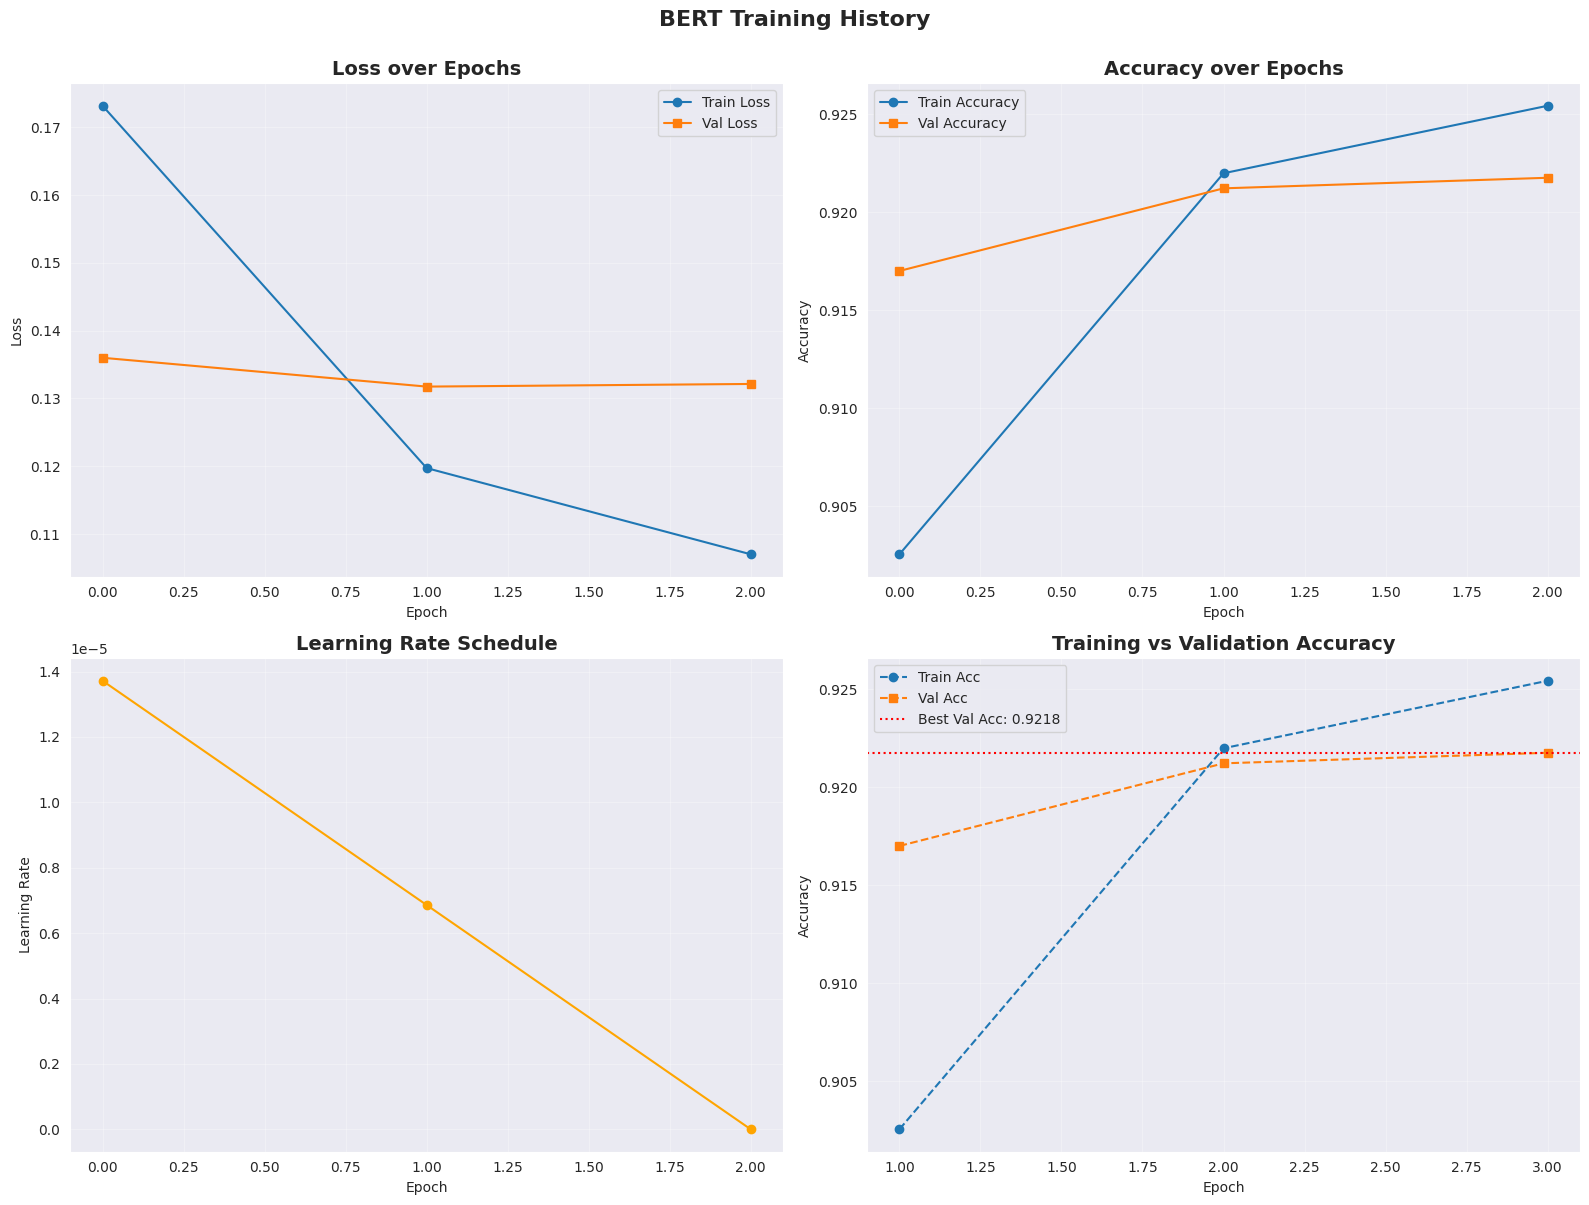


📊 Training Summary:
   Best validation loss: 0.1317
   Best validation accuracy: 0.9218
   Final train loss: 0.1070
   Final train accuracy: 0.9254


In [10]:
# ============================================================================
# CELL 9: Plot Training History
# ============================================================================
print("\n" + "="*80)
print("PLOTTING TRAINING HISTORY")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[0, 1].set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Learning Rate
axes[1, 0].plot(history['learning_rates'], marker='o', color='orange')
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].grid(alpha=0.3)

# Comparison
epochs = range(1, len(history['train_loss']) + 1)
axes[1, 1].plot(epochs, history['train_acc'], label='Train Acc', marker='o', linestyle='--')
axes[1, 1].plot(epochs, history['val_acc'], label='Val Acc', marker='s', linestyle='--')
axes[1, 1].axhline(y=max(history['val_acc']), color='r', linestyle=':',
                   label=f'Best Val Acc: {max(history["val_acc"]):.4f}')
axes[1, 1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('BERT Training History', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'training_history.png', dpi=300, bbox_inches='tight')
print("✅ Training history plot saved!")
plt.show()

# Print summary
print("\n📊 Training Summary:")
print(f"   Best validation loss: {min(history['val_loss']):.4f}")
print(f"   Best validation accuracy: {max(history['val_acc']):.4f}")
print(f"   Final train loss: {history['train_loss'][-1]:.4f}")
print(f"   Final train accuracy: {history['train_acc'][-1]:.4f}")

In [15]:
# ============================================================================
# CELL 10: Load Best Model
# ============================================================================
print("="*80)
print("LOADING BEST MODEL")
print("="*80)

import torch
from src.model import FakeNewsClassifier
from src.config import ModelConfig

best_model_path = MODELS_DIR / ModelConfig.BEST_MODEL_NAME

# Load checkpoint
checkpoint = torch.load(best_model_path, map_location=device)

# Initialize model
model = FakeNewsClassifier(
    model_name=ModelConfig.MODEL_NAME,
    num_labels=ModelConfig.NUM_LABELS,
    dropout_rate=ModelConfig.DROPOUT_RATE
)

# Load state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"\n✅ Loaded best model from: {best_model_path}")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"   Validation Accuracy: {checkpoint['val_accuracy']:.4f}")


LOADING BEST MODEL


ImportError: cannot import name 'load_checkpoint' from 'src.model' (/content/Fake_News_Detection_BERT/src/model.py)

In [12]:
# ============================================================================
# CELL 11: Evaluate on Test Set
# ============================================================================
print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)

evaluator = Evaluator(best_model, device=device)
test_metrics = evaluator.evaluate(test_loader, save_results=True)

print("\n📊 Test Set Results:")
print(f"   Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"   Precision: {test_metrics['precision']:.4f}")
print(f"   Recall:    {test_metrics['recall']:.4f}")
print(f"   F1-Score:  {test_metrics['f1_score']:.4f}")
print(f"   ROC-AUC:   {test_metrics['roc_auc']:.4f}")


EVALUATING ON TEST SET


NameError: name 'best_model' is not defined

In [13]:
# ============================================================================
# CELL 12: Compare with Baseline
# ============================================================================
print("\n" + "="*80)
print("COMPARISON WITH BASELINE")
print("="*80)

# Load baseline results (if available)
baseline_metrics = {
    'accuracy': 0.85,   # Example - replace with actual baseline results
    'precision': 0.84,
    'recall': 0.86,
    'f1_score': 0.85
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline (TF-IDF + LR)': [
        baseline_metrics['accuracy'],
        baseline_metrics['precision'],
        baseline_metrics['recall'],
        baseline_metrics['f1_score'],
        0.90  # Approximate
    ],
    'BERT Model': [
        test_metrics['accuracy'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1_score'],
        test_metrics['roc_auc']
    ]
})

comparison_df['Improvement'] = comparison_df['BERT Model'] - comparison_df['Baseline (TF-IDF + LR)']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline (TF-IDF + LR)']) * 100

print("\n📊 Model Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline (TF-IDF + LR)'],
              width, label='Baseline', color='skyblue')
bars2 = ax.bar(x + width/2, comparison_df['BERT Model'],
              width, label='BERT', color='salmon')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline vs BERT Model Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✅ Comparison plot saved!")
plt.show()



COMPARISON WITH BASELINE


NameError: name 'test_metrics' is not defined

In [ ]:
# ============================================================================
# CELL 13: Test Sample Predictions
# ============================================================================
print("\n" + "="*80)
print("TESTING SAMPLE PREDICTIONS")
print("="*80)

def predict_text(text, model, tokenizer, device):
    """Predict single text"""
    model.eval()

    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=ModelConfig.MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Predict
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1)

    return prediction.item(), probs[0].cpu().numpy()

# Test samples
test_samples = [
    "Breaking news: Scientists discover cure for cancer in major breakthrough",
    "You won't believe what happened next! Click here for shocking truth",
    "The president announced new economic policies in a press conference today",
    "Aliens landed in New York and nobody noticed! Government cover-up exposed"
]

print("\n🔍 Sample Predictions:\n")
for i, text in enumerate(test_samples, 1):
    pred, probs = predict_text(text, best_model, tokenizer, device)
    print(f"Sample {i}:")
    print(f"   Text: {text}")
    print(f"   Prediction: {'FAKE' if pred == 1 else 'REAL'}")
    print(f"   Confidence: Real={probs[0]:.3f}, Fake={probs[1]:.3f}")
    print()

In [ ]:
# ============================================================================
# CELL 14: Save Final Report
# ============================================================================
print("\n" + "="*80)
print("GENERATING FINAL REPORT")
print("="*80)

final_report = {
    "model_name": ModelConfig.MODEL_NAME,
    "training_config": {
        "epochs": ModelConfig.NUM_EPOCHS,
        "batch_size": ModelConfig.BATCH_SIZE,
        "learning_rate": ModelConfig.LEARNING_RATE,
        "max_length": ModelConfig.MAX_LENGTH
    },
    "training_history": {
        "best_val_loss": min(history['val_loss']),
        "best_val_acc": max(history['val_acc']),
        "final_train_loss": history['train_loss'][-1],
        "final_train_acc": history['train_acc'][-1]
    },
    "test_metrics": test_metrics,
    "comparison": comparison_df.to_dict()
}

from src.utils import save_json
report_path = RESULTS_DIR / 'metrics' / 'final_report.json'
save_json(final_report, report_path)

print(f"✅ Final report saved to: {report_path}")


In [ ]:
# ============================================================================
# CELL 15: Summary
# ============================================================================
print("\n" + "="*80)
print("🎉 TRAINING COMPLETE!")
print("="*80)

print("\n📌 Summary:")
print(f"   ✓ Model trained: {ModelConfig.MODEL_NAME}")
print(f"   ✓ Best validation accuracy: {max(history['val_acc']):.4f}")
print(f"   ✓ Test accuracy: {test_metrics['accuracy']:.4f}")
print(f"   ✓ Test F1-Score: {test_metrics['f1_score']:.4f}")
print(f"   ✓ Model saved: {MODELS_DIR / ModelConfig.BEST_MODEL_NAME}")

print("\n🎯 Next Steps:")
print("   1. Deploy model to production (Phase 3)")
print("   2. Build FastAPI backend")
print("   3. Create Next.js frontend")
print("   4. Set up MongoDB database")

print("\n" + "="*80)